In [1]:
# David Vizgan
# HW #1
# ASTR 596

import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# This just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

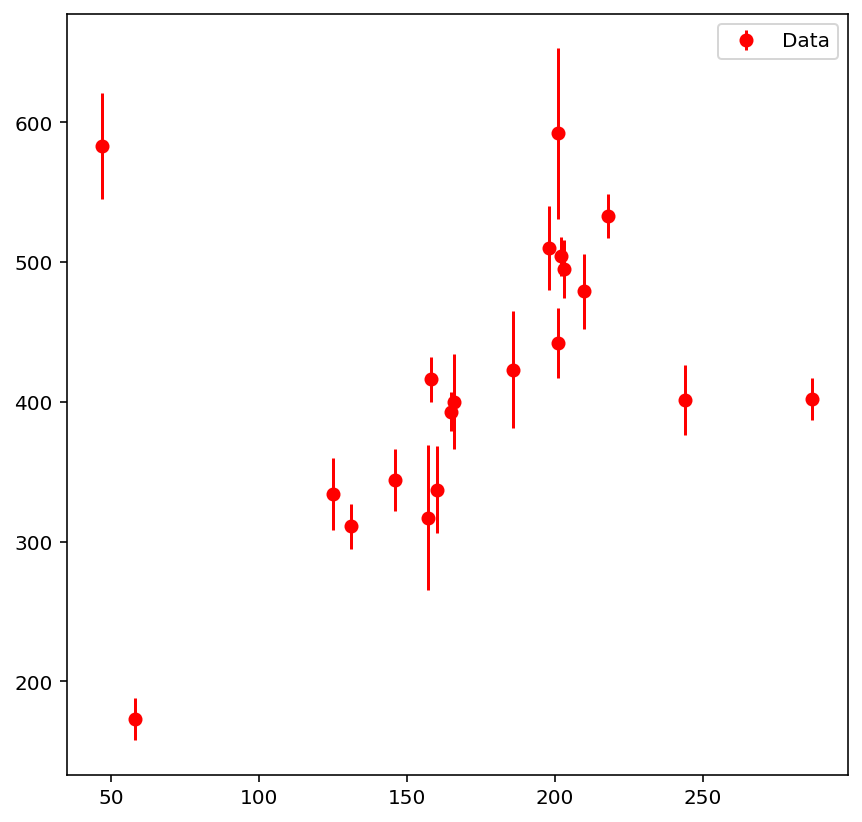

In [3]:
# First question: how does our data look?

plt.figure(figsize=[7,7])
plt.errorbar(x,y, yerr=dy, marker='o', linestyle='none', color='red', label='Data')
plt.legend()
plt.show()

In [5]:
a = np.linspace(0, 10, 500)
b = np.linspace(0, 1000, 500)

combos = [(slope, intercept) for slope in a for intercept in b]

slope_arr = []
intercept_arr = []
ln_L_arr = []

for slope, intercept in combos:
    
# Write a function that computes the squared loss, and incorporates the uncertainties on the measurements, dy (10 pts)

    y_model = slope * x + intercept + dy
    ln_L = np.sum((-1/dy**2) * (y_model - y)**2)
    
# Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)

    slope_arr.append(slope)
    intercept_arr.append(intercept)
    ln_L_arr.append(ln_L)
        
index = np.argmax(ln_L_arr)
best_slope = slope_arr[index]
best_int = intercept_arr[index]

print('slope: ' + str(best_slope) + ", " + "intercept: " + str(best_int))

slope: 1.0821643286573146, intercept: 192.38476953907815


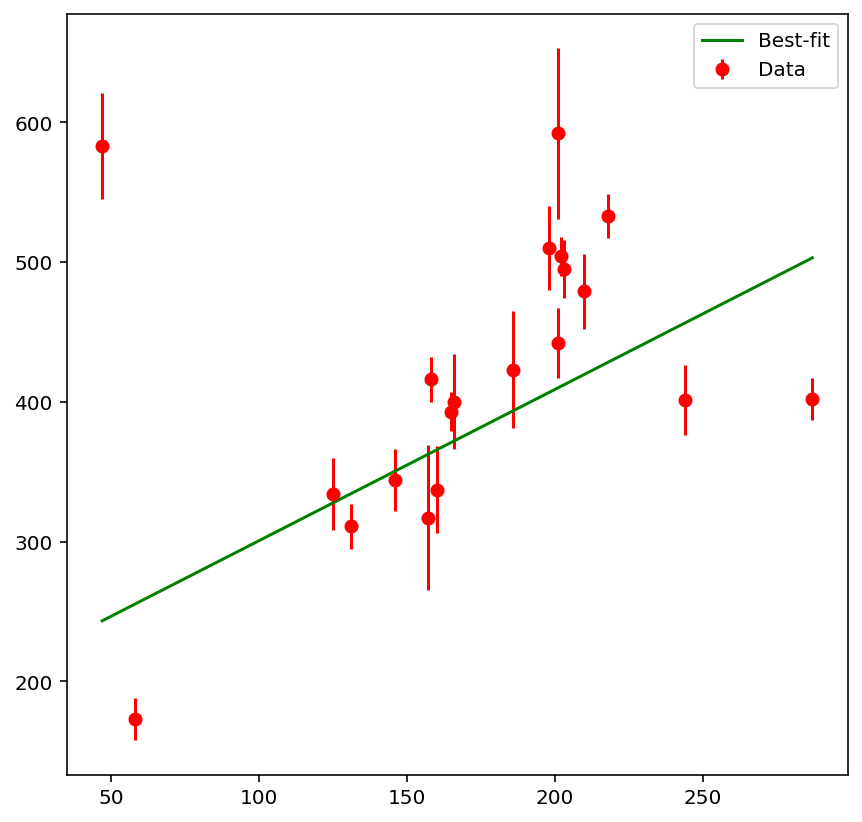

In [6]:
# Plotting best-fit line to data now

x_extent = np.linspace(np.min(x), np.max(x), len(x))

plt.figure(figsize=[7,7])
plt.errorbar(x,y, yerr=dy, marker='o', linestyle='none', color='red', label='Data')
plt.plot(x_extent, best_slope * x_extent + best_int, label='Best-fit', color='green')
plt.legend()

In [8]:
# Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts)

data = np.vstack([x, y, dy])
data_clipped = []
outliers = []
residuals = []

# going for sigma-clipping...

for i in range(data.shape[1]):
    x_i = data[0, i]
    y_i = data[1, i]
    dy_i = data[2, i]
    y_modelled = (best_slope * x_i + best_int + dy_i)
    if abs(y_i - y_modelled) > 3*dy_i: #if model - data > 3 sigma...
        outliers.append([x_i, y_i, dy_i])
    else:
        data_clipped.append([x_i, y_i, dy_i])
        residuals.append(y_i - y_modelled)
        
data_clipped = np.array(data_clipped).T #transpose array for ease of coding
outliers = np.array(outliers).T

adj_slope_arr = []
adj_int_arr = []
adj_ln_L_arr = []

for slope, intercept in combos:

    y_model = slope * data_clipped[0] + intercept + data_clipped[2]
    ln_L = np.sum((-1/data_clipped[2]**2) * (y_model - data_clipped[1])**2)
    
    adj_slope_arr.append(slope)
    adj_int_arr.append(intercept)
    adj_ln_L_arr.append(ln_L)
        
adj_index = np.argmax(adj_ln_L_arr)
adj_best_slope = adj_slope_arr[adj_index]
adj_best_int = adj_int_arr[adj_index]

print('slope: ' + str(adj_best_slope) + ", " + "intercept: " + str(adj_best_int))

slope: 2.124248496993988, intercept: 26.052104208416832


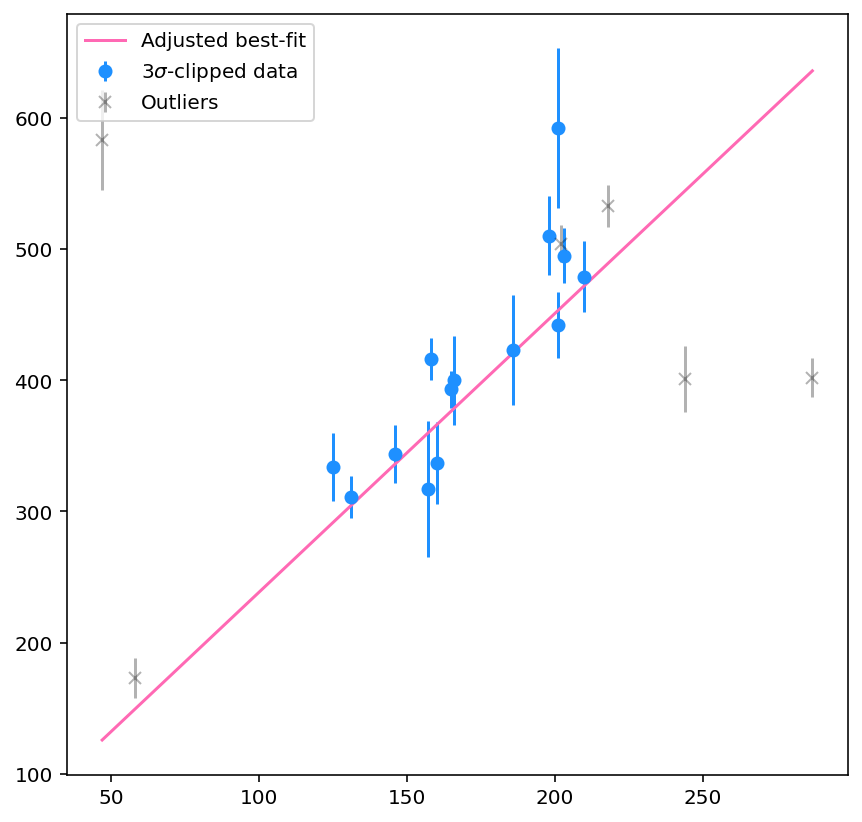

In [9]:
plt.figure(figsize=[7,7])
plt.errorbar(data_clipped[0], data_clipped[1], yerr=data_clipped[2], marker='o', linestyle='none', color='dodgerblue', label=r'3$\sigma$-clipped data')
plt.errorbar(outliers[0], outliers[1], yerr=outliers[2], marker='x', linestyle='none', color='black', label='Outliers', alpha=0.3)
plt.plot(x_extent, adj_best_slope * x_extent + adj_best_int, color='hotpink', label='Adjusted best-fit')
plt.legend()

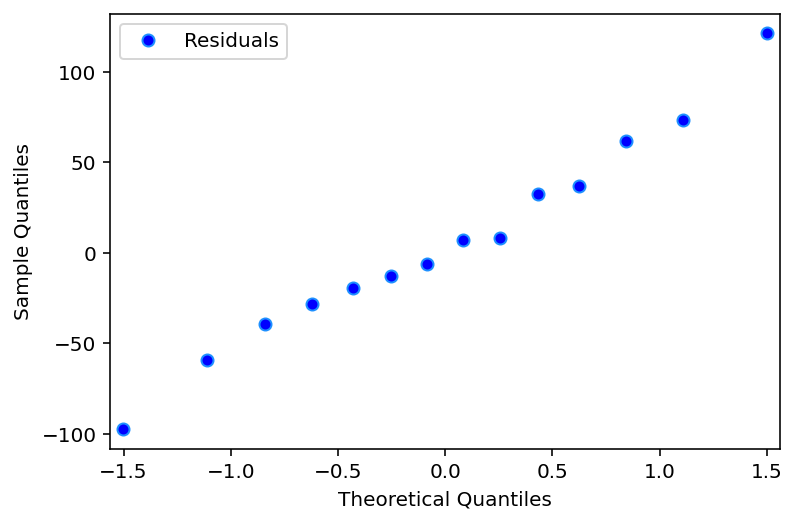

In [10]:
# and make a QQ plot of the residuals (10 pts)

import statsmodels.api as sm

sm.qqplot(np.array(residuals), label='Residuals', color='dodgerblue')
plt.legend()

In [11]:
# Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties dy (10 pts)

from scipy.optimize import fmin

huber_loss_arr = []

delta=20

def huber_loss_func(params): # functional form taken from Wikipedia
    
    y_model = params[0] * x + params[1] + dy
    qq = y_model - y
    
    for i in qq:
    
        if np.abs(i) < delta:
            huber_loss = 0.5 * qq**2
        
        else:
            huber_loss = (delta * (np.abs(qq) - (0.5 * delta)))

    huber_loss_arr.append(huber_loss)
    huber = np.sum(huber_loss)
    
    return huber

Optimization terminated successfully.
         Current function value: 26547.500146
         Iterations: 154
         Function evaluations: 294
slope: 1.9749996868354756, intercept: 13.650045505252029


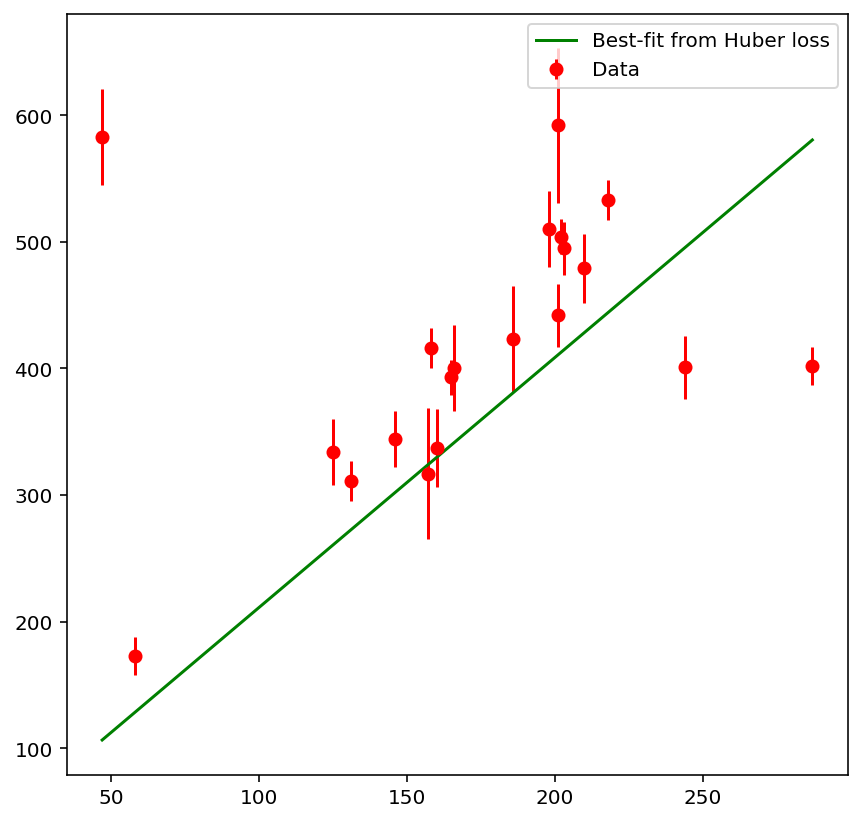

In [12]:
# Fit a new line to all of the data (no outlier rejection) with the new Huber likelihood, 
# except now use scipy.optimize.fmin instead of a grid search    

huber_vals = fmin(huber_loss_func, x0=[1,1])
huber_slope = huber_vals[0]
huber_int = huber_vals[1]

print('slope: ' + str(huber_slope) + ", " + "intercept: " + str(huber_int))

x_extent = np.linspace(np.min(x), np.max(x), len(x))

# Replotting the data...

plt.figure(figsize=[7,7])
plt.errorbar(x,y, yerr=dy, marker='o', linestyle='none', color='red', label='Data')
plt.plot(x_extent, huber_slope * x_extent + huber_int, label='Best-fit from Huber loss', color='green')
plt.legend()

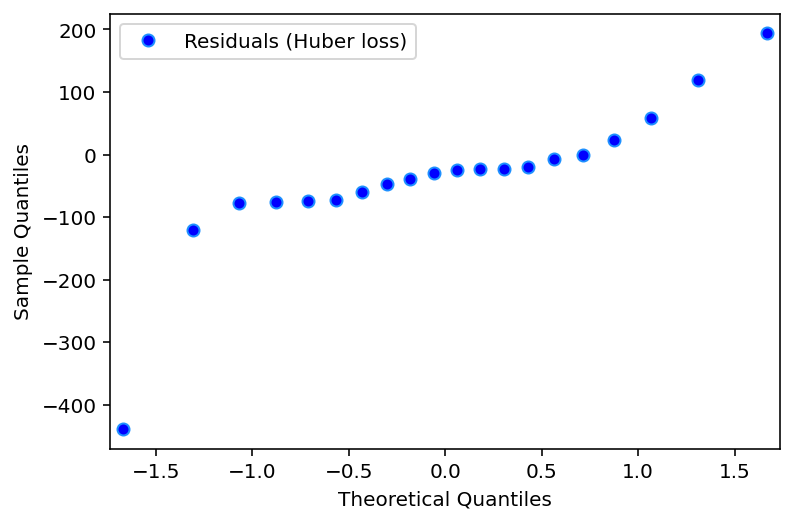

In [13]:
# and you know the drill by now - QQ plot of the residuals (10 pts)

huber_residuals = (huber_slope * x + huber_int + dy) - y

sm.qqplot(np.array(huber_residuals), label='Residuals (Huber loss)', color='dodgerblue')
plt.legend()

In [16]:
# QUESTION 2 

# Import CSV file

import pandas as pd

df = pd.read_csv('Cepheids.csv')

# Split the data into LMC and SMC, and then again by mode F and 1

LMC_F = df.loc[(df['Cloud'] == 'LMC') & (df['Mode'] == 'F')]
LMC_1 = df.loc[(df['Cloud'] == 'LMC') & (df['Mode'] == '1')]

SMC_F = df.loc[(df['Cloud'] == 'SMC') & (df['Mode'] == 'F')]
SMC_1 = df.loc[(df['Cloud'] == 'SMC') & (df['Mode'] == '1')]

In [17]:
m = np.linspace(-5, 5, 100)
x = np.linspace(0, 20, 100)

# Fit or estimate straight lines to each of the four samples using your solution to Problem 1 (10 pts) and plot the W on the y-axis vs log(P1) on x. 

def best_fit(xx, yy):
    
# probably should have just written a function in the first place, but oh well. Will use the first part of the solution to Problem 1 as it was easier :D

    combos = [(slope, intercept) for slope in m for intercept in x]

    slope_arr = []
    intercept_arr = []
    ln_L_arr = []

    for slope, intercept in combos:

        y_model = slope * xx + intercept
        ln_L = np.sum((-1/2) * (y_model - yy)**2)
    
        slope_arr.append(slope)
        intercept_arr.append(intercept)
        ln_L_arr.append(ln_L)
        
    index = np.argmax(ln_L_arr)
    best_slope = slope_arr[index]
    best_int = intercept_arr[index]

    return best_slope, best_int

def extent(x):
    
    extent = np.linspace(np.min(x), np.max(x), len(x))
    return extent

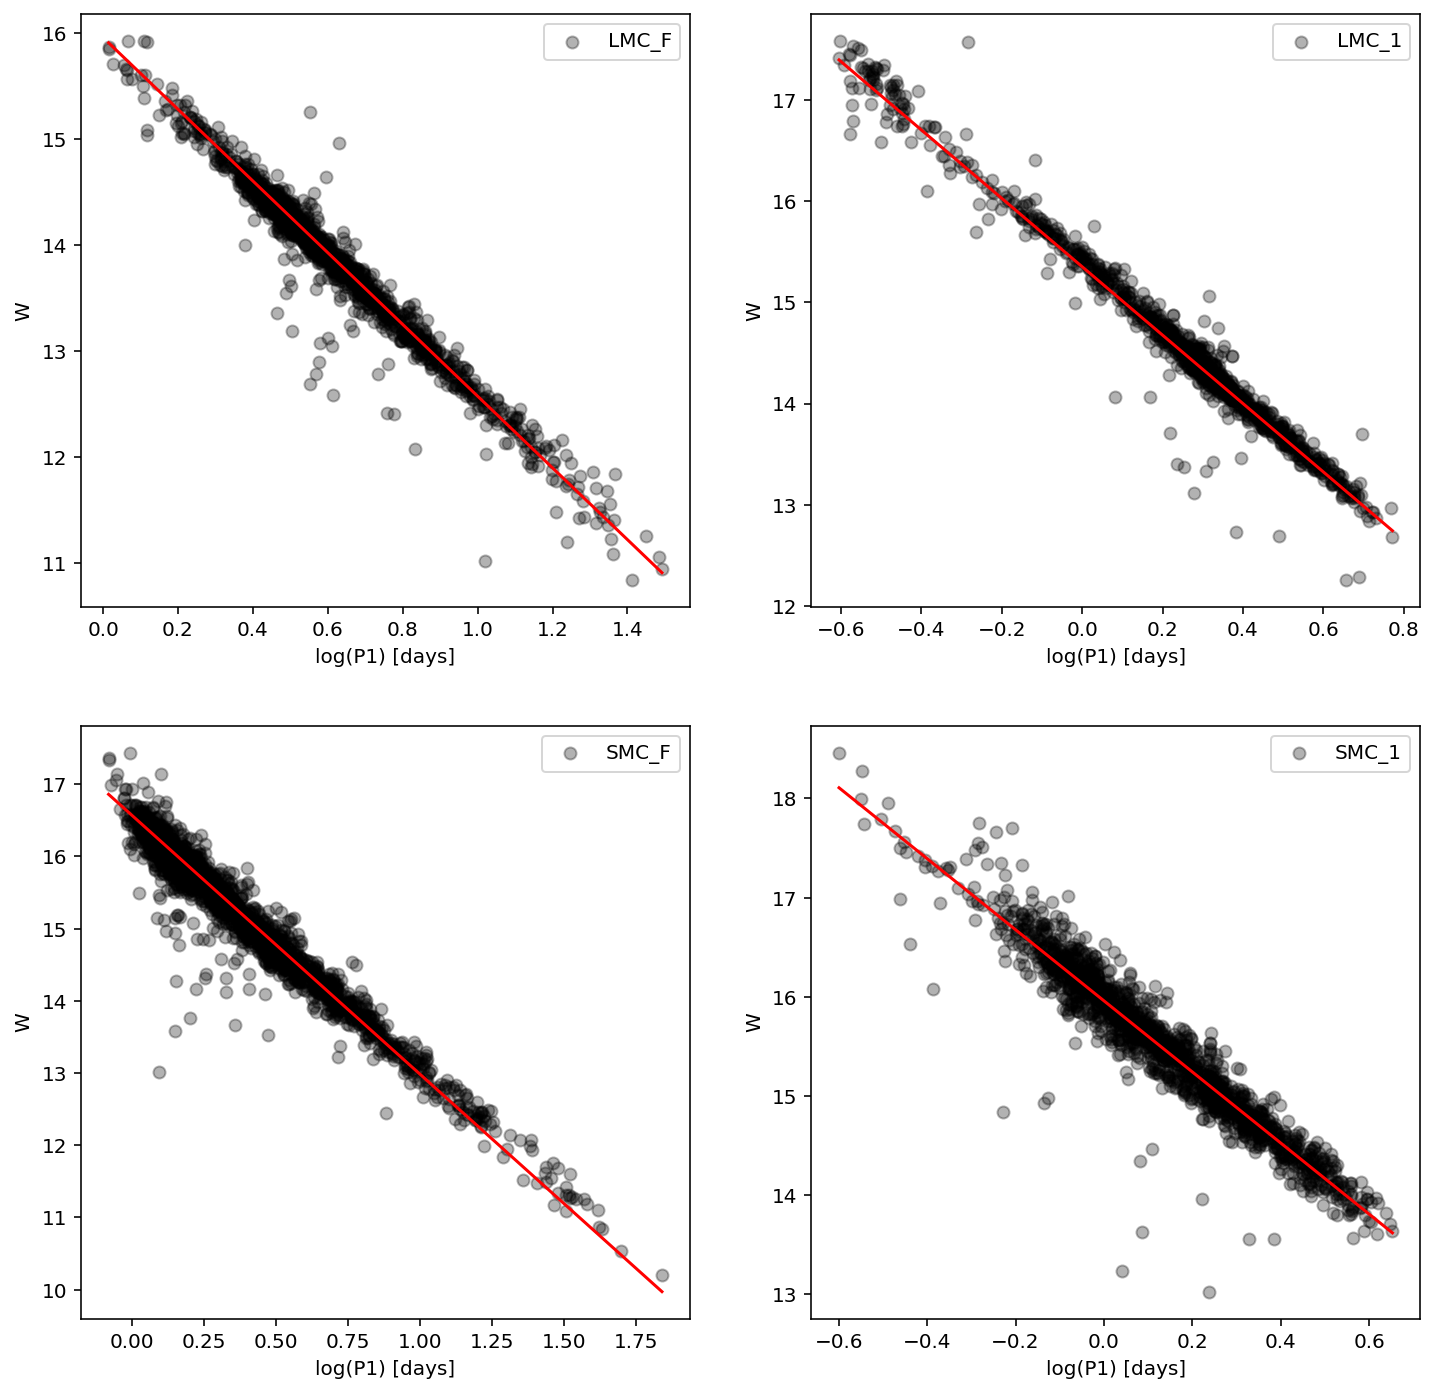

In [18]:
fig, ax = plt.subplots(2,2, figsize=[12,12])

ax[0,0].scatter(LMC_F.logP1, LMC_F.W, color='black', alpha=0.3, label='LMC_F')
ax[0,0].plot(extent(LMC_F.logP1), best_fit(np.array(LMC_F.logP1), np.array(LMC_F.W))[0] * extent(LMC_F.logP1) + best_fit(np.array(LMC_F.logP1), np.array(LMC_F.W))[1], color='red')
ax[0,0].set_xlabel('log(P1) [days]')
ax[0,0].set_ylabel('W')
ax[0,0].legend()

ax[0,1].scatter(LMC_1.logP1, LMC_1.W, color='black', alpha=0.3, label='LMC_1')
ax[0,1].plot(extent(LMC_1.logP1), best_fit(np.array(LMC_1.logP1), np.array(LMC_1.W))[0] * extent(LMC_1.logP1) + best_fit(np.array(LMC_1.logP1), np.array(LMC_1.W))[1], color='red')
ax[0,1].set_xlabel('log(P1) [days]')
ax[0,1].set_ylabel('W')
ax[0,1].legend()

ax[1,0].scatter(SMC_F.logP1, SMC_F.W, color='black', alpha=0.3, label='SMC_F')
ax[1,0].plot(extent(SMC_F.logP1), best_fit(np.array(SMC_F.logP1), np.array(SMC_F.W))[0] * extent(SMC_F.logP1) + best_fit(np.array(SMC_F.logP1), np.array(SMC_F.W))[1], color='red')
ax[1,0].set_xlabel('log(P1) [days]')
ax[1,0].set_ylabel('W')
ax[1,0].legend()

ax[1,1].scatter(SMC_1.logP1, SMC_1.W, color='black', alpha=0.3, label='SMC_1')
ax[1,1].plot(extent(SMC_1.logP1), best_fit(np.array(SMC_1.logP1), np.array(SMC_1.W))[0] * extent(SMC_1.logP1) + best_fit(np.array(SMC_1.logP1), np.array(SMC_1.W))[1], color='red')
ax[1,1].set_xlabel('log(P1) [days]')
ax[1,1].set_ylabel('W')
ax[1,1].legend()

plt.show()

In [19]:
# Compute the residuals of each sample to its respective line. 

def residuals_q2(xx,yy):
    
    y_model = best_fit(xx,yy)[0] * xx + best_fit(xx,yy)[1]
    residuals = y_model - yy
    
    return residuals

LMC_F_residuals = residuals_q2(np.array(LMC_F.logP1), np.array(LMC_F.VI))
LMC_1_residuals = residuals_q2(np.array(LMC_1.logP1), np.array(LMC_1.VI))
SMC_F_residuals = residuals_q2(np.array(SMC_F.logP1), np.array(SMC_F.VI))
SMC_1_residuals = residuals_q2(np.array(SMC_1.logP1), np.array(SMC_1.VI))

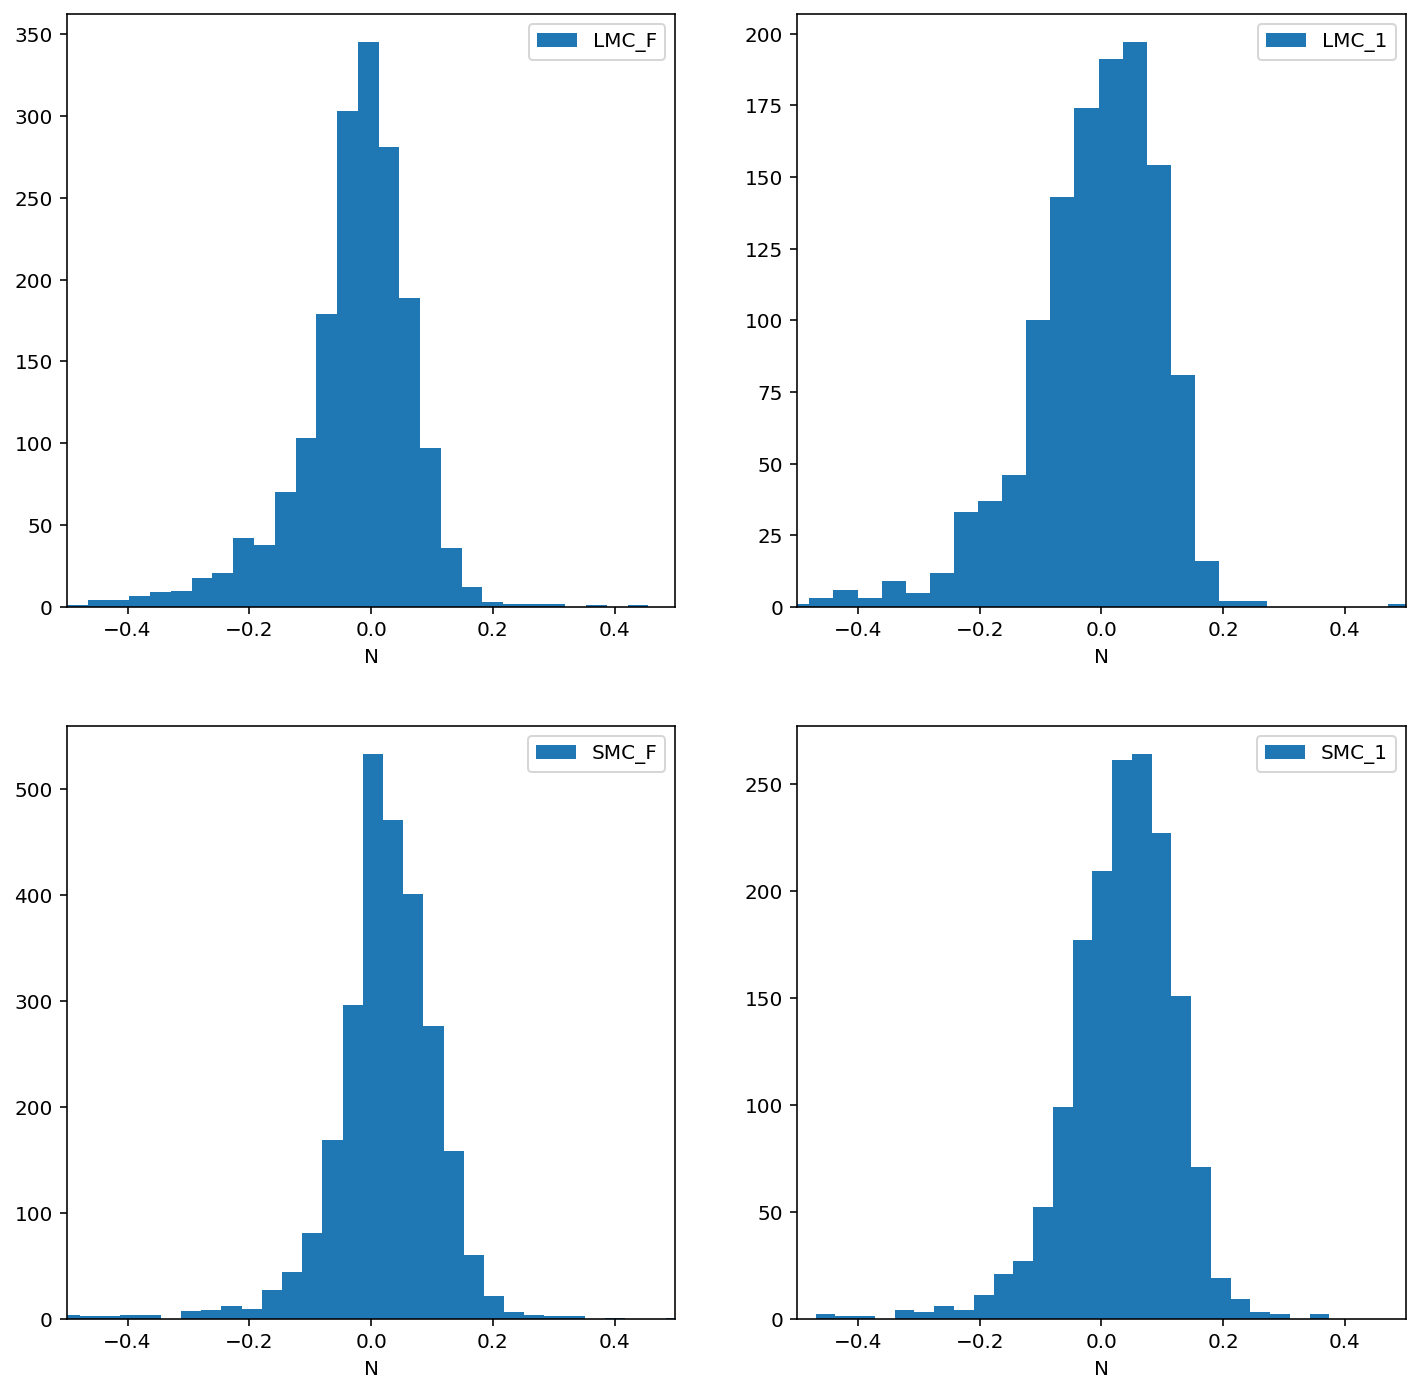

In [21]:
# Do these residuals look like a normal distribution? 
# If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

fig, ax = plt.subplots(2,2, figsize=[12,12])

ax[0,0].hist(LMC_F_residuals, bins=50, label='LMC_F')
ax[0,0].legend()
ax[0,0].set_xlabel('N')
ax[0,0].set_xlim(-0.5, 0.5)

ax[0,1].hist(LMC_1_residuals, bins=50, label='LMC_1')
ax[0,1].legend()
ax[0,1].set_xlabel('N')
ax[0,1].set_xlim(-0.5, 0.5)

ax[1,0].hist(SMC_F_residuals, bins=50, label='SMC_F')
ax[1,0].legend()
ax[1,0].set_xlabel('N')
ax[1,0].set_xlim(-0.5, 0.5)

ax[1,1].hist(SMC_1_residuals, bins=50, label='SMC_1')
ax[1,1].legend()
ax[1,1].set_xlabel('N')
ax[1,1].set_xlim(-0.5, 0.5)

plt.show()

# My speculation:

# The residuals do not really (but perhaps vaguely) resemble normal distributions, and all of them exhibit a sharp peak around
# a residual value of zero. On one hand my model does not incorporate any uncertainty or error from the data, which would
# certainly explain the behavior in these histograms. Furthermore, though the period of Cepheid stars correlates strongly with their,
# luminosities, perhaps the relationship with the "W-index" is less direct or requires another variable in the equation, which would cause our
# model to be overly simplistic, and hence explaining the behavior we see here.

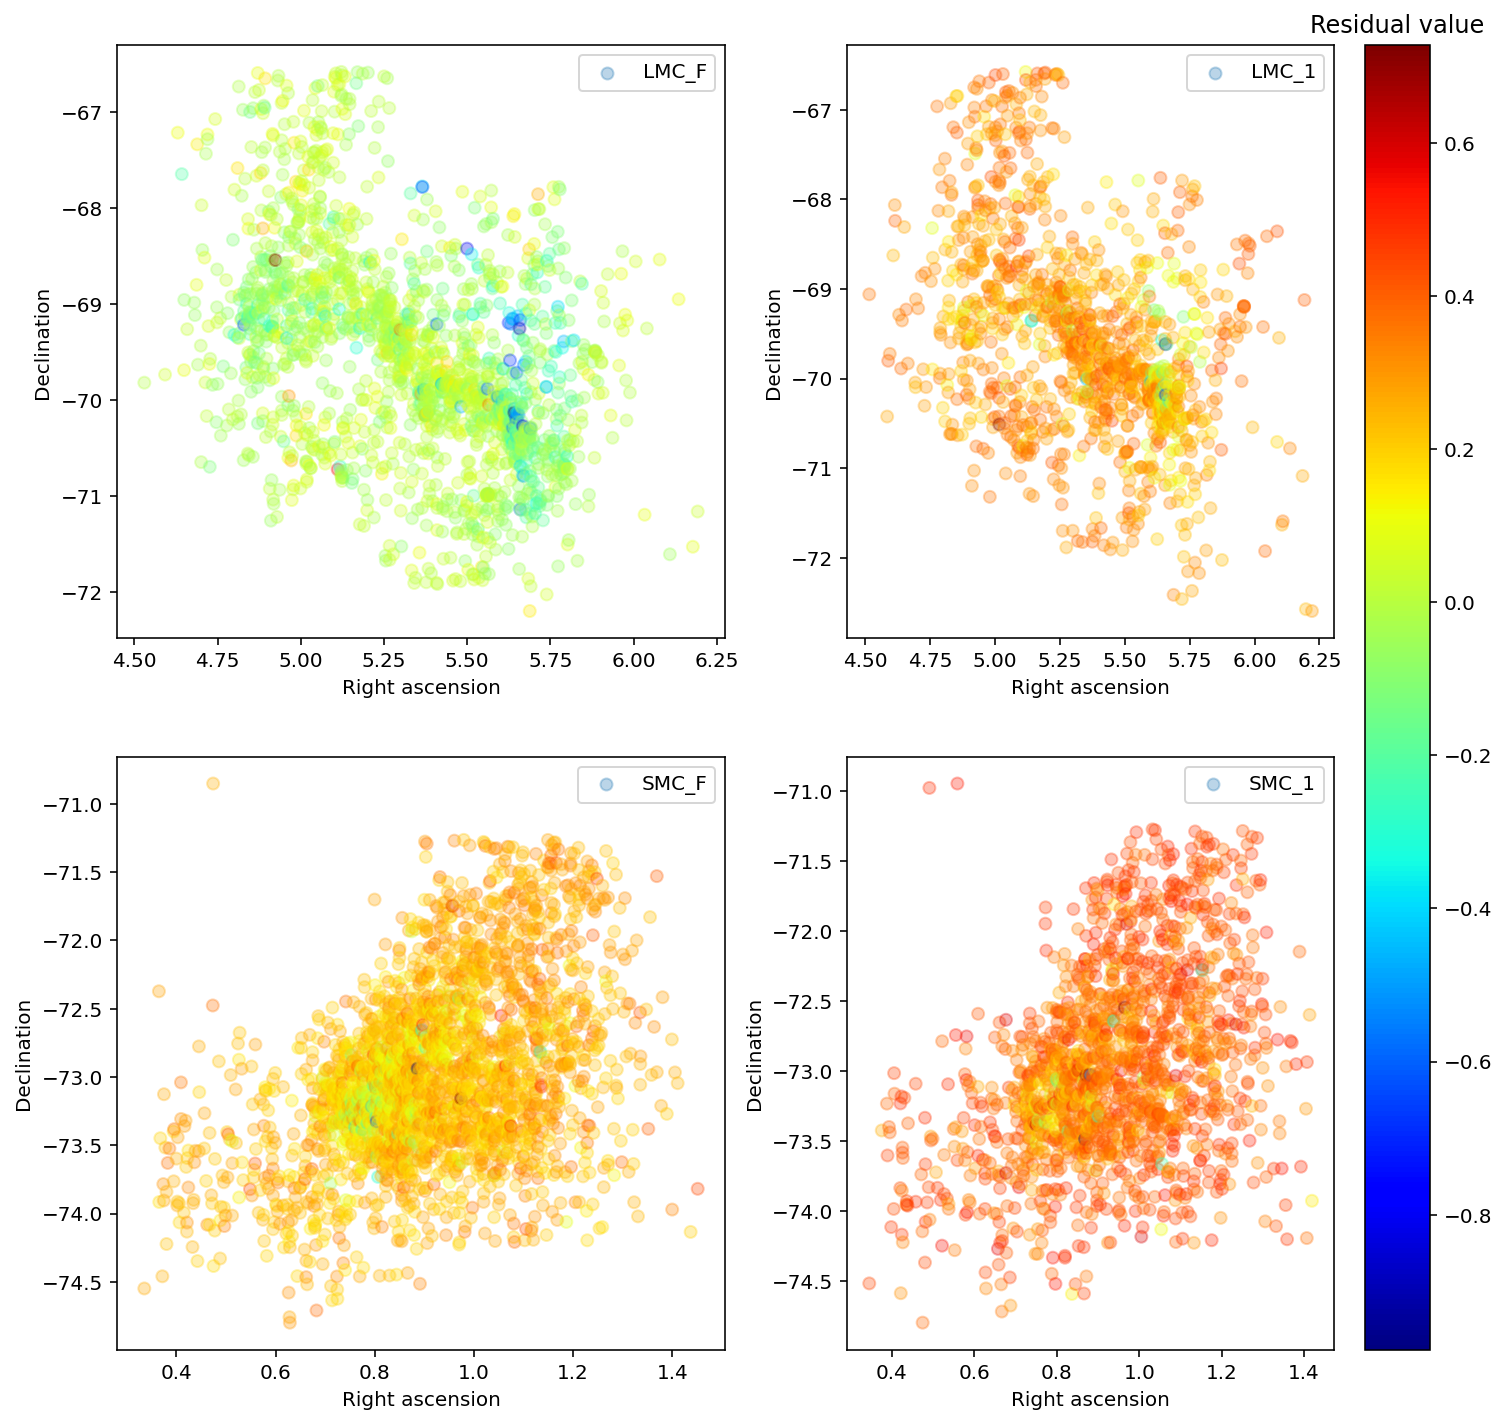

In [22]:
# Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

from matplotlib.cm import ScalarMappable

cmap='jet'

fig, ax = plt.subplots(2,2, figsize=[12,12])

ax[0,0].scatter(LMC_F.RA0, LMC_F.Decl0, c=LMC_F_residuals, label='LMC_F', cmap=cmap, alpha=0.3)
ax[0,0].set_xlabel('Right ascension')
ax[0,0].set_ylabel('Declination')
ax[0,0].legend()

ax[0,1].scatter(LMC_1.RA0, LMC_1.Decl0, c=LMC_1_residuals, label='LMC_1', cmap=cmap, alpha=0.3)
ax[0,1].set_xlabel('Right ascension')
ax[0,1].set_ylabel('Declination')
ax[0,1].legend()

ax[1,0].scatter(SMC_F.RA0, SMC_F.Decl0, c=SMC_F_residuals, label='SMC_F', cmap=cmap, alpha=0.3)
ax[1,0].set_xlabel('Right ascension')
ax[1,0].set_ylabel('Declination')
ax[1,0].legend()

ax[1,1].scatter(SMC_1.RA0, SMC_1.Decl0, c=SMC_1_residuals, label='SMC_1', cmap=cmap, alpha=0.3)
ax[1,1].set_xlabel('Right ascension')
ax[1,1].set_ylabel('Declination')
ax[1,1].legend()

scales = np.linspace(np.min(LMC_F_residuals), np.max(LMC_F_residuals), 7)
norm = plt.Normalize(scales.min(), scales.max())
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax[:,1])
cbar.ax.set_title("Residual value")

plt.show()

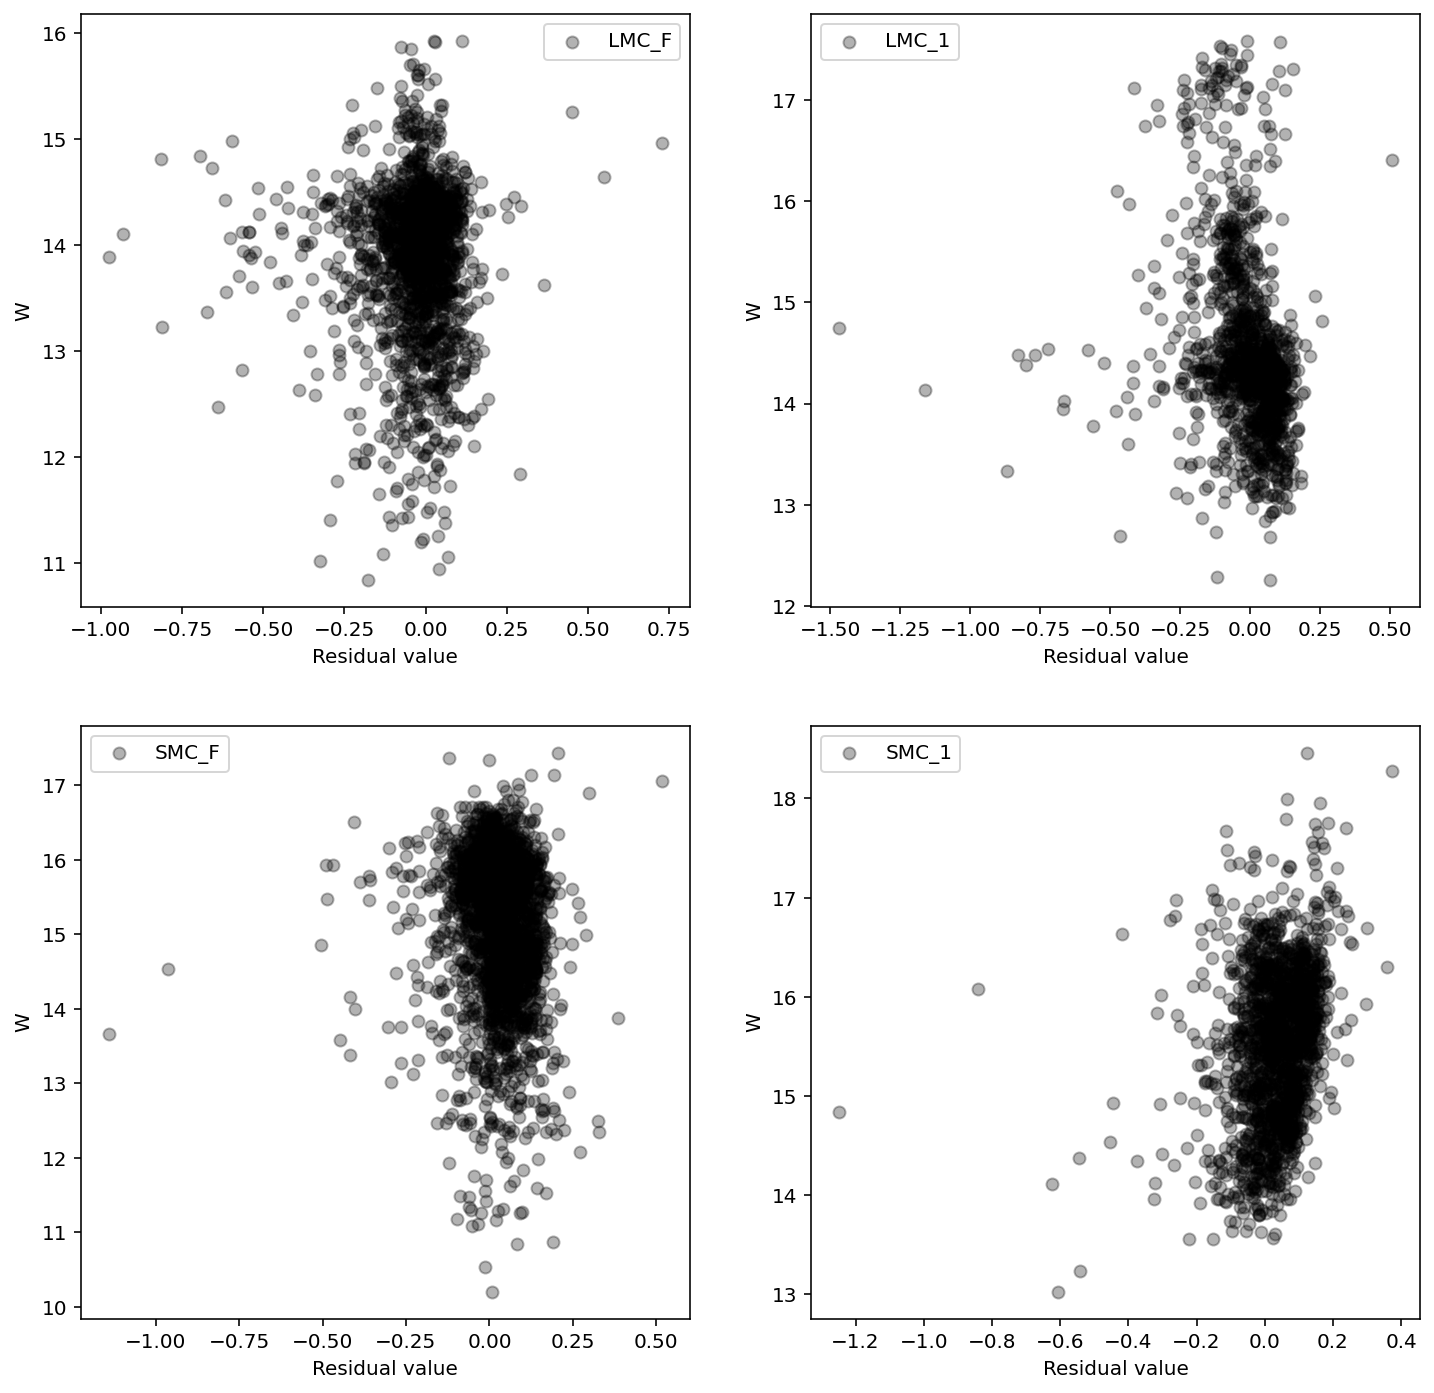

In [23]:
# Finally, plot the residuals against the fitted W values

fig, ax = plt.subplots(2,2, figsize=[12,12])

ax[0,0].scatter(LMC_F_residuals, LMC_F.W, label='LMC_F', color='black', alpha=0.3)
ax[0,0].set_xlabel('Residual value')
ax[0,0].set_ylabel('W')
ax[0,0].legend()

ax[0,1].scatter(LMC_1_residuals, LMC_1.W, label='LMC_1', color='black', alpha=0.3)
ax[0,1].set_xlabel('Residual value')
ax[0,1].set_ylabel('W')
ax[0,1].legend()

ax[1,0].scatter(SMC_F_residuals, SMC_F.W, label='SMC_F', color='black', alpha=0.3)
ax[1,0].set_xlabel('Residual value')
ax[1,0].set_ylabel('W')
ax[1,0].legend()

ax[1,1].scatter(SMC_1_residuals, SMC_1.W, label='SMC_1', color='black', alpha=0.3)
ax[1,1].set_xlabel('Residual value')
ax[1,1].set_ylabel('W')
ax[1,1].legend()

plt.show()

# Here we see essentially no correlation between the residual value and W, meaning that our model is pretty good or
# that, at the very least, it is not degenerate with the W index.

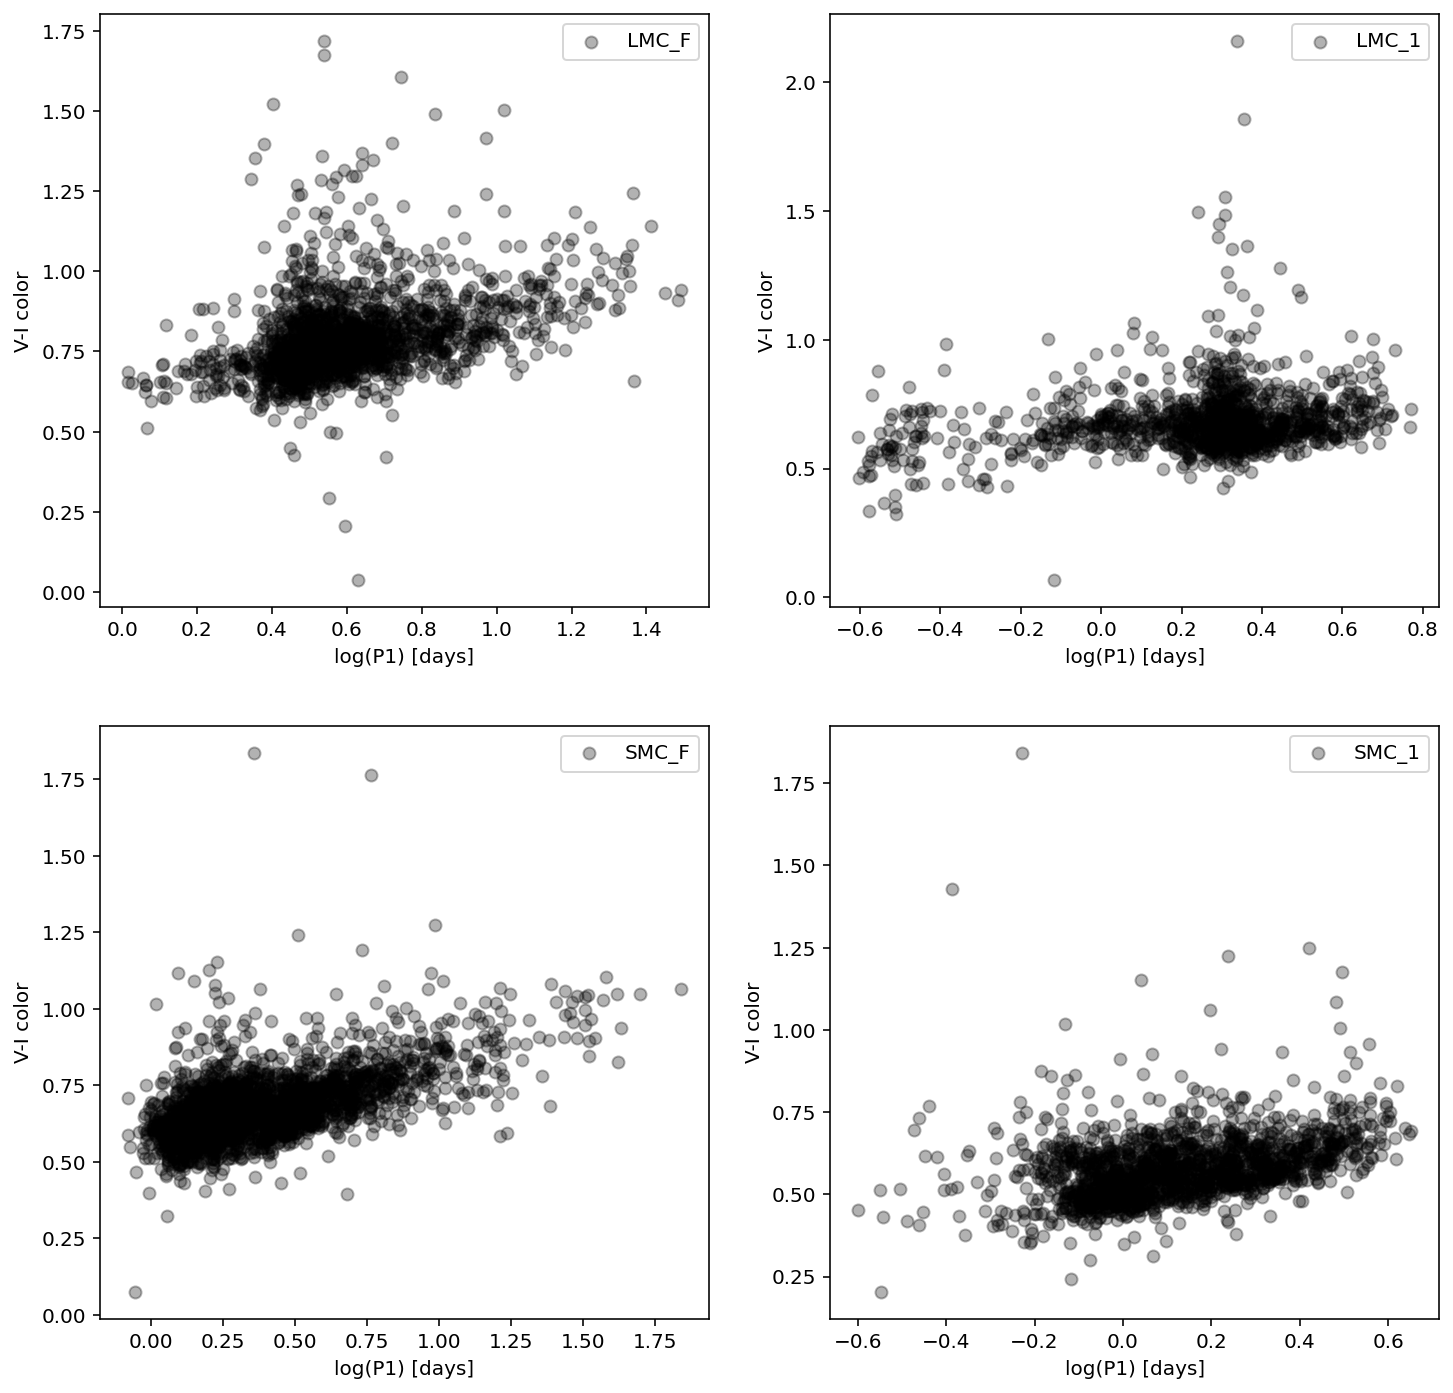

In [24]:
# And just to anticipate the next homework assignment, also plot log(P1) vs V-I. Comment on what you are seeing. (15 pts)

fig, ax = plt.subplots(2,2, figsize=[12,12])

ax[0,0].scatter(LMC_F.logP1, LMC_F.VI, label='LMC_F', color='black', alpha=0.3)
ax[0,0].set_xlabel('log(P1) [days]')
ax[0,0].set_ylabel('V-I color')
ax[0,0].legend()

ax[0,1].scatter(LMC_1.logP1, LMC_1.VI, label='LMC_1', color='black', alpha=0.3)
ax[0,1].set_xlabel('log(P1) [days]')
ax[0,1].set_ylabel('V-I color')
ax[0,1].legend()

ax[1,0].scatter(SMC_F.logP1, SMC_F.VI, label='SMC_F', color='black', alpha=0.3)
ax[1,0].set_xlabel('log(P1) [days]')
ax[1,0].set_ylabel('V-I color')
ax[1,0].legend()

ax[1,1].scatter(SMC_1.logP1, SMC_1.VI, label='SMC_1', color='black', alpha=0.3)
ax[1,1].set_xlabel('log(P1) [days]')
ax[1,1].set_ylabel('V-I color')
ax[1,1].legend()

plt.show()

# My comment

# Here we do see tenous linear relationships between period and V-I color, which is a bit strange given the nature 
# of the histograms above. You would think that these would look somewhat similar to the first plots we made for 
# this problem, since W = I - 1.55(V-I). Clearly that is not the case.